### Introduction 

Imagine you want to know what is happening behind your computer screen, who are your most active contacts and their personality. For this purpose, you will analyze their stories and try to extract their emotions from their written sentences.

We will develop a machine learning model that can classify the sentences according to their principal emotion.

We will work with two datasets :
- one from Kaggle (Emotion_final.csv)
- one from data.world (text_emotion.csv)

In [1]:
# import some librairies
from time import time
from collections import defaultdict

import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.decomposition import FastICA, KernelPCA, TruncatedSVD, SparsePCA, NMF, FactorAnalysis, LatentDirichletAllocation
import nltk

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

### I . Analysis and classification on the first dataset

In [2]:
# Kaggle data
df1=pd.read_csv('Emotion_final.csv')

In [3]:
df1.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


As we can see above, we have 21459 non-null rows and 2 columns in the Kaggle dataset

<AxesSubplot:>

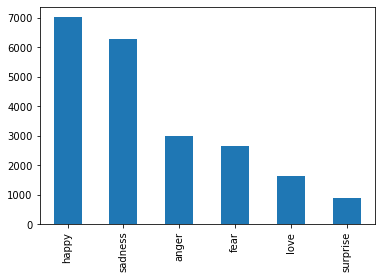

In [5]:
df1['Emotion'].value_counts().plot(kind='bar')

The "happy" and "sadness" emotions are the two main emotions that stand out.

### Preprocessing data

#### Stop words removal

We will suppress words that do not have any semantic or sentimental value/weight in a sentence such as pronouns or auxiliary verbs. We can also remove punctuations.

In [6]:
stopwords = set(nltk.corpus.stopwords.words("english"))

In [7]:
exclude = set(string.punctuation)
stopwords=stopwords.union(exclude) #we add the punctuation to the previous stop words list

#### Lemmatization

Lemmatization is the process of converting a word to its base form. For example, it would identify the base form of 'sleeping' to 'sleep'. 

In [8]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')


# let's create a function which can do the lemmatization
lemma = WordNetLemmatizer()
def lemmatize(sent):
    tokens=word_tokenize(sent.lower())
    tokens=[lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w,'v'),'n'),'a') for w in tokens]
    return ' '.join(tokens)

df1['Text']=df1['Text'].apply(lambda sent: lemmatize(sent))
np.array(df1['Text'])

array(['i didnt feel humiliate',
       'i can go from feel so hopeless to so damn hopeful just from be around someone who care and be awake',
       'im grab a minute to post i feel greedy wrong', ...,
       'vincent be irritate but not dismay',
       'kendall-hume turn back to face the dismay coup',
       'i be dismay , but not surpris'], dtype=object)

#### Counting the words after the preprocessing data

vocabulary size : 14384


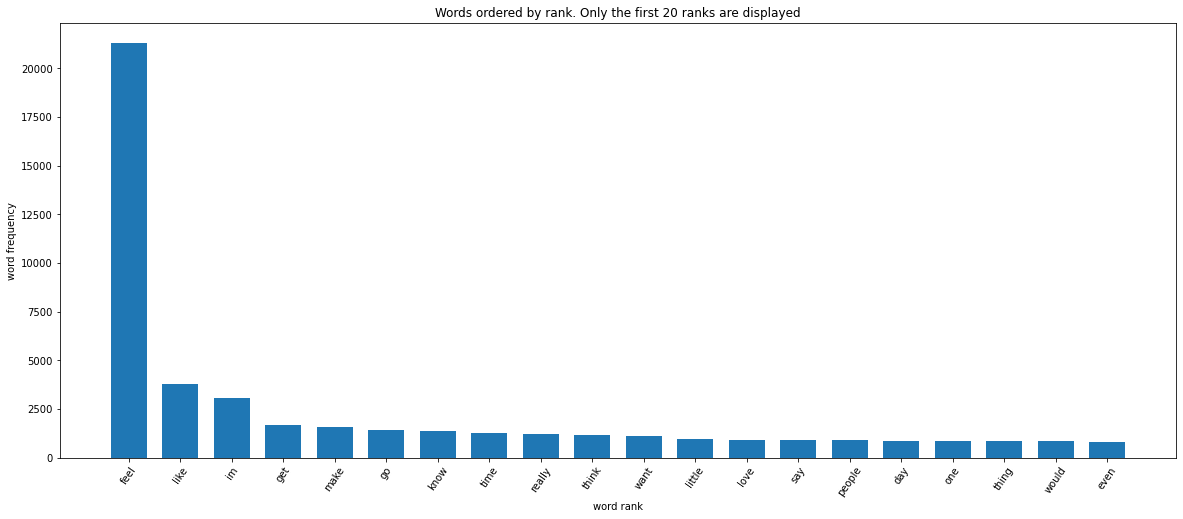

In [9]:
# Remind which the corpus and the targets are
corpus= np.array(df1['Text'])
targets = np.array(df1['Emotion'])



# Vobabulary analysis
vec = CountVectorizer(stop_words=stopwords)
X = vec.fit_transform(corpus)
words = vec.get_feature_names()

print("vocabulary size : %d" % len(words) )

# Compute rank
wsum = np.array(X.sum(0))[0]
ix = wsum.argsort()[::-1]
wrank = wsum[ix] 
labels = [words[i] for i in ix]

# Sub-sample the data to plot.
# take the 20 first
def subsample(x):
    return np.hstack(x[:20])


plt.figure(figsize=(20,8))
freq = subsample(wrank)
r = np.arange(len(freq))
plt.bar(r, freq, width=0.7)
plt.xticks(r, subsample(labels), rotation=55)
plt.xlabel('word rank')
plt.ylabel('word frequency')
plt.title("Words ordered by rank. Only the first 20 ranks are displayed");

#### Creating the pipelines 

A pipeline is the process of tying together different pieces of the machine learning process.Each stage of a pipeline is fed data processed from its preceding stage. The output of a processing unit is supplied as the input to the next step. The data flows through the pipeline just as water flows in a pipe. 
Here we are going to use 5 differents classifiers with CountVectorizer.

In [10]:
# Linear Support Vector Machines
pipe1 = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords)),
    ('svml', LinearSVC()),
])

# Logistic Regression
pipe2 = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords)),
    ('logit', LogisticRegression(max_iter=1000)),
])

# Multinomial Naive Bayes
pipe3 = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords)),
    ('mult_nb', MultinomialNB()),
])

# Complement Naive Bayes classifier 
pipe4 = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords)),
    ('compl_nb', ComplementNB()),
])

# Naive Bayes classifier for multivariate Bernoulli models
pipe5 = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords)),
    ('bern_nb', BernoulliNB()),
])

In [11]:
# We create a function capable of training and testing our dataset with each classifier

def run_pipes(pipes, splits=10, test_size=0.2, seed=42):  
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed)
    for idx_train, idx_test in spliter.split(corpus):
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])
            
            # extract datasets
            X_train = corpus[idx_train]
            X_test = corpus[idx_test]
            y_train = targets[idx_train]
            y_test = targets[idx_test]
            
            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start
            
            # predict and save results
            y = pipe.predict(X_test)
            print(name)
            print(classification_report(y_test, y))
            res[name].append([
                fit_time,
                precision_score(y_test, y,average='weighted'),
                recall_score(y_test, y,average='weighted'),
                f1_score(y_test, y,average='weighted'),
            
            ])
            
    return res

def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time" : arr[:, 0][0].round(2),
            "precision_score": arr[:,1][0].round(2),
            "recall_score":arr[:, 2][0].round(2),
            "f1_score":arr[:, 3][0].round(2),
        }

    df = pd.DataFrame.from_dict(final, orient="index").reset_index()
    return df


In [12]:
corpus= np.array(df1['Text'])
targets = np.array(df1['Emotion'])

# run base pipes and displaying the classification reports
res1 = run_pipes([pipe1, pipe2,pipe3,pipe4,pipe5], splits=1)

vect-svml
              precision    recall  f1-score   support

       anger       0.88      0.85      0.87       617
        fear       0.83      0.82      0.83       531
       happy       0.89      0.91      0.90      1381
        love       0.75      0.71      0.73       318
     sadness       0.90      0.91      0.91      1277
    surprise       0.68      0.73      0.70       168

    accuracy                           0.87      4292
   macro avg       0.82      0.82      0.82      4292
weighted avg       0.87      0.87      0.87      4292

vect-logit
              precision    recall  f1-score   support

       anger       0.90      0.84      0.87       617
        fear       0.85      0.84      0.84       531
       happy       0.89      0.92      0.90      1381
        love       0.77      0.70      0.73       318
     sadness       0.90      0.92      0.91      1277
    surprise       0.73      0.76      0.74       168

    accuracy                           0.87      4292
  

In [13]:
print_table(res1)

,index,time,precision_score,recall_score,f1_score
0,vect-svml,6.72,0.87,0.87,0.87
1,vect-logit,18.35,0.87,0.87,0.87
2,vect-mult_nb,1.50,0.80,0.78,0.75
3,vect-compl_nb,1.46,0.87,0.87,0.87
4,vect-bern_nb,1.46,0.69,0.68,0.62


If we look at the table above, we can see the Bernouilli classifier got the worst F1 score whereas the logistic regression, the linear support vector machines and the Complement Naive Bayes classifier got the best F1 score. Now let's try these pipelines with the second dataset.

### II . Analysis and classification on the second dataset (data.world)

In [14]:
# Loading the dataframe
df2=pd.read_csv('text_emotion.csv')

In [15]:
df2.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


There are 40000 rows and 4 columns on this dataset.

<AxesSubplot:>

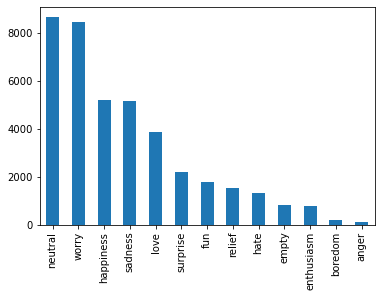

In [17]:
df2['sentiment'].value_counts().plot(kind='bar')

The sentiments 'neutral' and 'worry' have the highest frequency in the data.world dataset.

### Preprocessing data

In [18]:
# As recipient's name is not very useful in our dataset we decide to remove all the words starting with an @
def atremove(txt):
    quote=' '.join(word for word in txt.split(' ') if not word.startswith('@'))
    return quote

In [19]:
atremove('@tiffanylue i know i was listenin') 

'i know i was listenin'

In [20]:
df2['content']=df2['content'].apply(lambda x: atremove(x))
df2['content']=df2['content'].apply(lambda sent: lemmatize(sent))
np.array(df2['content'])

array(['i know i be listenin to bad habit early and i start freakin at his part = [',
       'layin n bed with a headache ughhhh ... waitin on your call ...',
       'funeral ceremony ... gloomy friday ...', ...,
       "happy mother 's day to all the mommy out there , be you woman or man a long a you 're 'momma ' to someone this be your day !",
       'wassup beautiful ! ! ! follow me ! ! peep out my new hit single www.myspace.com/ipsohot i def . wat u in the video ! !',
       'bullet train from tokyo the gf and i have be visit japan since thursday vacation/sightseeing gaijin godzilla'],
      dtype=object)

vocabulary size; 27511


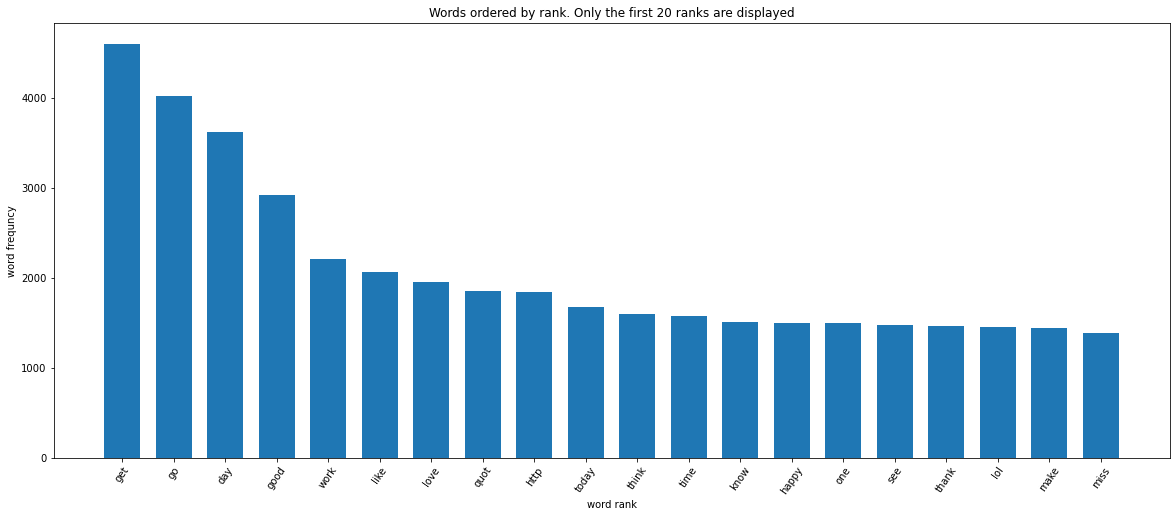

In [21]:
# Vobabulary analysis
corpus=df2['content']
targets=df2['sentiment']

vec = CountVectorizer(stop_words=stopwords)
X = vec.fit_transform(corpus)
words = vec.get_feature_names()

print("vocabulary size; %d" % len(words) )

# Compute rank
wsum = np.array(X.sum(0))[0]
ix = wsum.argsort()[::-1]
wrank = wsum[ix] 
labels = [words[i] for i in ix]

# Sub-sample the data to plot.
# take the 20 first + the rest sample with the given step 
def subsample(x):
    return np.hstack((x[:20]))


plt.figure(figsize=(20,8))
freq = subsample(wrank)
r = np.arange(len(freq))
plt.bar(r, freq, width=0.7)
plt.xticks(r, subsample(labels), rotation=55)
plt.xlabel('word rank')
plt.ylabel('word frequncy')
plt.title("Words ordered by rank. Only the first 20 ranks are displayed");


#### Running the pipelines for the second dataset

In [22]:
corpus= np.array(df2['content'])
targets = np.array(df2['sentiment'])

# run base pipes
res2 = run_pipes([pipe1, pipe2,pipe3,pipe4,pipe5], splits=1)

/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


vect-svml
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.06      0.03      0.04        31
       empty       0.02      0.01      0.02       162
  enthusiasm       0.03      0.01      0.02       163
         fun       0.06      0.04      0.05       338
   happiness       0.29      0.29      0.29      1028
        hate       0.25      0.18      0.21       268
        love       0.36      0.36      0.36       762
     neutral       0.34      0.46      0.39      1740
      relief       0.14      0.07      0.09       352
     sadness       0.28      0.27      0.28      1046
    surprise       0.13      0.08      0.10       425
       worry       0.32      0.35      0.33      1666

    accuracy                           0.30      8000
   macro avg       0.18      0.17      0.17      8000
weighted avg       0.27      0.30      0.28      8000

vect-logit


/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.05      0.01      0.01       162
  enthusiasm       0.06      0.01      0.01       163
         fun       0.12      0.05      0.07       338
   happiness       0.33      0.33      0.33      1028
        hate       0.34      0.18      0.23       268
        love       0.46      0.39      0.42       762
     neutral       0.35      0.57      0.43      1740
      relief       0.24      0.05      0.08       352
     sadness       0.31      0.28      0.29      1046
    surprise       0.14      0.05      0.07       425
       worry       0.33      0.40      0.36      1666

    accuracy                           0.34      8000
   macro avg       0.21      0.18      0.18      8000
weighted avg       0.31      0.34      0.31      8000



/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


vect-mult_nb


/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.00      0.00      0.00       338
   happiness       0.32      0.33      0.32      1028
        hate       0.27      0.01      0.02       268
        love       0.49      0.32      0.39       762
     neutral       0.33      0.39      0.36      1740
      relief       0.00      0.00      0.00       352
     sadness       0.32      0.17      0.22      1046
    surprise       0.50      0.01      0.02       425
       worry       0.29      0.65      0.40      1666

    accuracy                           0.32      8000
   macro avg       0.19      0.15      0.13      8000
weighted avg       0.30      0.32      0.27      8000



/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


vect-compl_nb
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.02      0.01      0.01       162
  enthusiasm       0.03      0.01      0.01       163
         fun       0.08      0.05      0.06       338
   happiness       0.27      0.37      0.31      1028
        hate       0.26      0.22      0.24       268
        love       0.35      0.48      0.40       762
     neutral       0.33      0.24      0.28      1740
      relief       0.17      0.06      0.09       352
     sadness       0.28      0.29      0.29      1046
    surprise       0.15      0.08      0.10       425
       worry       0.32      0.43      0.37      1666

    accuracy                           0.29      8000
   macro avg       0.17      0.17      0.17      8000
weighted avg       0.27      0.29      0.27      8000

vect-bern_nb


/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        31
       empty       0.00      0.00      0.00       162
  enthusiasm       0.00      0.00      0.00       163
         fun       0.00      0.00      0.00       338
   happiness       0.33      0.14      0.20      1028
        hate       0.00      0.00      0.00       268
        love       0.53      0.15      0.24       762
     neutral       0.30      0.67      0.41      1740
      relief       0.00      0.00      0.00       352
     sadness       0.33      0.05      0.08      1046
    surprise       0.00      0.00      0.00       425
       worry       0.30      0.60      0.40      1666

    accuracy                           0.31      8000
   macro avg       0.14      0.12      0.10      8000
weighted avg       0.26      0.31      0.23      8000



/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print_table(res2)

,index,time,precision_score,recall_score,f1_score
0,vect-svml,72.57,0.27,0.30,0.28
1,vect-logit,82.03,0.31,0.34,0.31
2,vect-mult_nb,2.60,0.30,0.32,0.27
3,vect-compl_nb,2.57,0.27,0.29,0.27
4,vect-bern_nb,2.46,0.26,0.31,0.23


The F1 scores are very low for all the classifiers. The reason may be the number of sentiments(13) which is higher than in the Kaggle dataset (6 different emotions only). Therefore there is a higher risk that an item might be misclassified.

### Can we improve the F1 score if we concatenate the two datasets ?

In [24]:
# We concatenate the two datasets by using only 2 columns from data.worls dataset
df3=df1.append(df2[['content','sentiment']].rename(columns={"content": "Text", "sentiment": "Emotion"}),ignore_index=True)

In [25]:
# It is necessary to merge all the rows with 'happiness' together with all the rows with 'happy'
df3.loc[(df3.Emotion == 'happiness'),'Emotion']='happy'
df3

,Text,Emotion
0,i didnt feel humiliate,sadness
1,i can go from feel so hopeless to so damn hope...,sadness
2,im grab a minute to post i feel greedy wrong,anger
3,i be ever feel nostalgic about the fireplace i...,love
4,i be feel grouchy,anger
...,...,...
61454,,neutral
61455,happy mother day all my love,love
61456,happy mother 's day to all the mommy out there...,love
61457,wassup beautiful ! ! ! follow me ! ! peep out ...,happy


<AxesSubplot:>

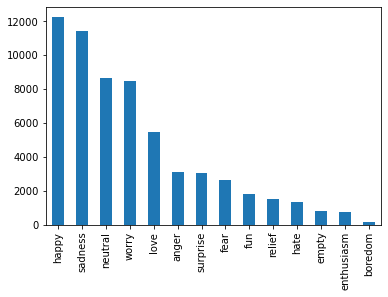

In [26]:
df3['Emotion'].value_counts().plot(kind='bar')

Happy, sadness, neutral and worry are the most frequent emotions in this combined dataset.

In [27]:
corpus= np.array(df3['Text'])
targets = np.array(df3['Emotion'])


# run base pipes
res3 = run_pipes([pipe1, pipe2,pipe3,pipe4,pipe5], splits=1)

/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


vect-svml
              precision    recall  f1-score   support

       anger       0.76      0.75      0.76       623
     boredom       0.08      0.03      0.04        34
       empty       0.03      0.01      0.02       160
  enthusiasm       0.02      0.01      0.01       160
        fear       0.81      0.81      0.81       531
         fun       0.08      0.04      0.05       382
       happy       0.61      0.63      0.62      2478
        hate       0.22      0.16      0.19       270
        love       0.49      0.46      0.47      1124
     neutral       0.32      0.46      0.38      1658
      relief       0.08      0.04      0.05       326
     sadness       0.58      0.60      0.59      2207
    surprise       0.30      0.25      0.27       605
       worry       0.30      0.29      0.29      1734

    accuracy                           0.47     12292
   macro avg       0.33      0.32      0.33     12292
weighted avg       0.46      0.47      0.46     12292

vect-logit
    

/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.88      0.39      0.54       623
     boredom       0.00      0.00      0.00        34
       empty       0.00      0.00      0.00       160
  enthusiasm       0.00      0.00      0.00       160
        fear       0.84      0.34      0.48       531
         fun       0.00      0.00      0.00       382
       happy       0.45      0.73      0.56      2478
        hate       0.67      0.01      0.01       270
        love       0.55      0.27      0.36      1124
     neutral       0.30      0.27      0.28      1658
      relief       0.00      0.00      0.00       326
     sadness       0.44      0.69      0.54      2207
    surprise       0.53      0.04      0.07       605
       worry       0.31      0.41      0.35      1734

    accuracy                           0.43     12292
   macro avg       0.36      0.22      0.23     12292
weighted avg       0.43      0.43      0.38     12292



/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


vect-compl_nb
              precision    recall  f1-score   support

       anger       0.61      0.76      0.68       623
     boredom       0.00      0.00      0.00        34
       empty       0.00      0.00      0.00       160
  enthusiasm       0.06      0.01      0.01       160
        fear       0.67      0.85      0.75       531
         fun       0.13      0.05      0.07       382
       happy       0.59      0.63      0.61      2478
        hate       0.27      0.14      0.18       270
        love       0.43      0.47      0.45      1124
     neutral       0.30      0.29      0.30      1658
      relief       0.04      0.01      0.02       326
     sadness       0.59      0.63      0.61      2207
    surprise       0.36      0.20      0.26       605
       worry       0.30      0.39      0.34      1734

    accuracy                           0.47     12292
   macro avg       0.31      0.32      0.31     12292
weighted avg       0.44      0.47      0.45     12292

vect-bern_n

/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.80      0.04      0.09       623
     boredom       0.00      0.00      0.00        34
       empty       0.00      0.00      0.00       160
  enthusiasm       0.00      0.00      0.00       160
        fear       0.83      0.02      0.04       531
         fun       0.00      0.00      0.00       382
       happy       0.48      0.70      0.57      2478
        hate       0.00      0.00      0.00       270
        love       0.60      0.12      0.20      1124
     neutral       0.31      0.57      0.40      1658
      relief       0.00      0.00      0.00       326
     sadness       0.42      0.68      0.52      2207
    surprise       1.00      0.00      0.00       605
       worry       0.32      0.34      0.33      1734

    accuracy                           0.40     12292
   macro avg       0.34      0.18      0.15     12292
weighted avg       0.44      0.40      0.33     12292



/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print_table(res3)

,index,time,precision_score,recall_score,f1_score
0,vect-svml,98.31,0.46,0.47,0.46
1,vect-logit,134.89,0.49,0.51,0.49
2,vect-mult_nb,3.76,0.43,0.43,0.38
3,vect-compl_nb,3.78,0.44,0.47,0.45
4,vect-bern_nb,3.84,0.44,0.40,0.33


The F1 scores seems to have improved compared to the second dataset only but the scores are still not very high compared to the first dataset.

### Conclusion

When we compare these results with those in the notebook with the raw data, we can see there is no such a difference between the scores regardless of the dataset. In fact some classifiers scores in the raw version of the notebook are even slightly higher than in the preprocessed version. We can conclude than removing some vocabulary from the dataset might affect the data processing and the results.